In [7]:
import warnings
import numpy as np
import pandas
import cvxpy as cp
from tqdm import tqdm
import pandas as pd
from scipy.stats import binom
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

Генерация распределения:

In [81]:
def generate_p():
    p = np.random.randint(0, 100)/100
    return p

In [5]:
def get_true_E(p, T):
    return p * T

def get_max_true_E(ps, T):
    return max([get_true_E(p, T) for p in ps])

Генерация выборки и тестов:

In [12]:
def generate_sample(p, a):
    def dg(n, T):
        return np.array([binom.rvs(T, pi) for pi in p])
    return dg

def generate_test(n, T, dg, delta, p):
    l, u = 0, T
    xi = dg(n, T)
    xi_with_noize = [] # испорченные
    for i in range(n):
        if np.random.uniform() < p and delta != 0:
            a, b = int(max(l, xi[i] - delta)), int(min(u, xi[i] + delta))
            xi_with_noize.append([a, b])
        else:
            xi_with_noize.append(xi[i])
    return xi, np.array(xi_with_noize)

Построение доверительного интервала:

In [104]:
def get_interval(sample, l, u, T, alpha):
    n = len(sample)
    epsilon = (u - l) * np.sqrt(np.log(2./alpha)/(2 * T))
    s_low, s_upper = 0, 0
    for i in sample:
        if type(i) != int and type(i) != np.int32:
            s_low += i[0]
            s_upper += i[1]
        else:
            s_low += i
            s_upper += i
    s_low /= n
    s_upper /= n
    return [max(l, s_low - epsilon), min(u, s_upper + epsilon)]

Решение задачи оптимизации:

In [105]:
def solve(n, T, samples, alpha):
    l, u = 0, T
    P = [get_interval([sample], 0, T, T, alpha) for sample in samples]
    p = [i[0] for i in P]
    q = cp.Variable(n, boolean = True)
    objective_func = sum([p[i] * q[i] for i in range(n)])

    x_sum = 0
    for i in range(n):        
        x_sum += q[i]

    constraints = []
    constraints.append(x_sum == 1)
    objective = cp.Maximize(objective_func)
    prob = cp.Problem(objective, constraints)

    prob.solve(verbose=False)
    return prob

In [106]:
def get_metric(a, b):
    return a/b

Моделирование:

In [178]:
ns = [10, 20, 100, 400, 600, 800, 1000]

In [261]:
results = []
for n in tqdm(ns):
    for T in [10, 100, 500, 1000]:
        for d in [(2 * T)//4]:
            for alpha in [0.01]:
                for p in [0.4, 0.8]:
                    A1, A2 = 0, 0
                    for _ in range(3):
                        ps = [generate_p() for i in range(n)]
                        xi, xi_with_noize = generate_test(n, T, generate_sample(ps, a), d, p)
                        a1, a2, t = solve(n, T, xi, alpha).value, solve(n, T, xi_with_noize, alpha).value, get_max_true_E(ps, T)
                        A1 += get_metric(a1, t)
                        A2 += get_metric(a2, t)
                    results.append({'n': n, 'T': T, 'd': d, 'alpha': alpha,
                                    'p': p, 'delta_comp': A1/3,
                                    'delta_incomp': A2/3})

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.38s/it]


In [262]:
df = pd.DataFrame(results)

Визуализация результатов:

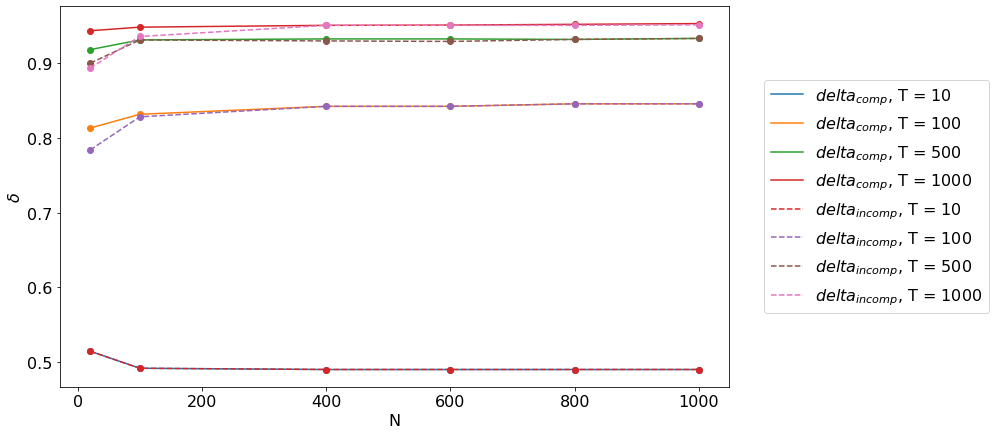

In [271]:
p = 0.4
d = 100

plt.rcParams['font.size'] = 16

plt.figure(figsize=(12, 7))

i = 0
for T in [10, 100, 500, 1000]:
    X = []
    for N in ns:
        df2 = df[df['n'] == N][df['alpha'] == 0.01][df['p'] == p][df['T'] == T]['delta_comp'].values[0]
        X.append(df2)
    plt.plot(ns, X, label='$delta_{comp}$, T = ' + str(T))
    plt.plot(ns, X, 'o', color='C'+str(i))
    i += 1
i = 3
for T in [10, 100, 500, 1000]:
    X = []
    for N in ns:
        df2 = df[df['n'] == N][df['alpha'] == 0.01][df['p'] == p][df['T'] == T]['delta_incomp'].values[0]
        X.append(df2)
    plt.plot(ns, X, '--', label='$delta_{incomp}$, T = ' + str(T), color='C' + str(i))
    plt.plot(ns, X, 'o', color='C' + str(i))
    i += 1
plt.xlabel('N')
plt.ylabel('$\delta$')
plt.legend(loc="center right", bbox_to_anchor=(1.4, 0.5))
plt.show()

<br>